# Import Library

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from geopy.geocoders import Nominatim
import folium
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import datapane as dp

**Comprensión empresarial**

La División de Bebidas Alcohólicas de Iowa es la autoridad de control de bebidas alcohólicas del estado estadounidense de Iowa. Desde el 8 de marzo de 1934, ha regulado el tráfico y ha mantenido un monopolio sobre la venta al por mayor de bebidas alcohólicas en el estado, convirtiendo así a Iowa en un estado de control de bebidas alcohólicas.

Los estados de control de bebidas alcohólicas, generalmente llamados estados de control, son 17 estados de los Estados Unidos que, a partir de 2016, tienen el monopolio estatal sobre la venta al por mayor o al por menor de algunas o todas las categorías de bebidas alcohólicas, como cerveza, vino y licores destilados.
comprensión de datos.

**Conjunto de datos de ventas minoristas de licores de Iowa**

Este conjunto de datos contiene todas las compras de licor al por mayor en el estado de Iowa por parte de minoristas para la venta a particulares desde el 1 de enero de 2012. El estado de Iowa controla la distribución al por mayor de licor destinado a la venta al por menor, lo que significa que este conjunto de datos ofrece una visión completa del comercio minorista. venta de licores en todo el estado. El conjunto de datos contiene todos los pedidos de licor al por mayor de todos los supermercados, licorerías, tiendas de conveniencia, etc., con detalles sobre la tienda y la ubicación, la marca y el tamaño exactos del licor y la cantidad de botellas pedidas.

Además de ser un excelente conjunto de datos para analizar las ventas de licores, este es un conjunto de datos público grande y limpio de datos de ventas minoristas.

Debido a la limitación de la cuenta gratuita, BiqQuery solo permite descargar 16000 filas de cada consulta. Por lo tanto, recopilaré una muestra del conjunto de datos de ventas minoristas de licores de Iowa mediante un muestreo estratificado. Recopilaré muestras de cada año a partir de 2012 hasta 2020. De esa manera, tendré un conjunto de datos distribuido uniformemente. El resultado de esta muestra se extrapolará a la población, que son todos los datos del conjunto de datos de ventas minoristas de licores de Iowa.

**A continuación se muestra la consulta SQL para recopilar las muestra**

Es importante mencionar que no es posible descargar el dataset completo debido a costos involucrados en Big Query de Google. Limite de 16.000. Por lo tanto, descargar todo el dataset por año con muestra distribuida uniformemente.

In [46]:
# BigQuery SQL Query

'''
#standardSQL
SELECT *, EXTRACT(ISOYEAR FROM iowa_liquor.date) as Year, 
FROM `bigquery-public-data.iowa_liquor_sales.sales` AS iowa_liquor
WHERE EXTRACT(ISOYEAR FROM iowa_liquor.date) = 2020 
    AND (iowa_liquor.store_location IS NULL) = FALSE
    AND (iowa_liquor.category IS NULL) = FALSE 
LIMIT 16000

'''

'\n#standardSQL\nSELECT *, EXTRACT(ISOYEAR FROM iowa_liquor.date) as Year, \nFROM `bigquery-public-data.iowa_liquor_sales.sales` AS iowa_liquor\nWHERE EXTRACT(ISOYEAR FROM iowa_liquor.date) = 2020 \n    AND (iowa_liquor.store_location IS NULL) = FALSE\n    AND (iowa_liquor.category IS NULL) = FALSE \nLIMIT 16000\n\n'

In [4]:
# Datapane Login Token
#dp.login(token="*****************")

# Carga de datos

In [10]:
iowa_2012 = pd.read_csv('/Users/sebastianmoyacamus/tensorflow-test/bq-IOWA/SRS_iowa_liquor_2012.csv')
iowa_2013 = pd.read_csv('/Users/sebastianmoyacamus/tensorflow-test/bq-IOWA/SRS_iowa_liquor_2013.csv')
iowa_2014 = pd.read_csv('/Users/sebastianmoyacamus/tensorflow-test/bq-IOWA/SRS_iowa_liquor_2014.csv')
iowa_2015 = pd.read_csv('/Users/sebastianmoyacamus/tensorflow-test/bq-IOWA/SRS_iowa_liquor_2015.csv')
iowa_2016 = pd.read_csv('/Users/sebastianmoyacamus/tensorflow-test/bq-IOWA/SRS_iowa_liquor_2016.csv')
iowa_2017 = pd.read_csv('/Users/sebastianmoyacamus/tensorflow-test/bq-IOWA/SRS_iowa_liquor_2017.csv')
iowa_2018 = pd.read_csv('/Users/sebastianmoyacamus/tensorflow-test/bq-IOWA/SRS_iowa_liquor_2018.csv')
iowa_2019 = pd.read_csv('/Users/sebastianmoyacamus/tensorflow-test/bq-IOWA/SRS_iowa_liquor_2019.csv')
iowa_2020 = pd.read_csv('/Users/sebastianmoyacamus/tensorflow-test/bq-IOWA/SRS_iowa_liquor_2020.csv')

In [11]:
# Create iowa_list variable
iowa_list = [iowa_2012, iowa_2013, iowa_2014, iowa_2015, iowa_2016, iowa_2017, iowa_2018, iowa_2019, iowa_2020]

# Create 'Month' and 'Quarter' columns for each dataset
for iowa in iowa_list:
    iowa['Month'] = pd.DatetimeIndex(iowa['date']).month
    iowa['Quarter'] = pd.DatetimeIndex(iowa['date']).quarter

In [12]:
iowa_df = pd.concat(iowa_list)
iowa_df.shape

(144000, 27)

In [13]:
# Check for missing value
iowa_df.isna().sum()

invoice_and_item_number      0
date                         0
store_number                 0
store_name                   0
address                      0
city                         0
zip_code                     1
store_location               0
county_number              635
county                     635
category                     0
category_name              474
vendor_number                0
vendor_name                  0
item_number                  0
item_description             0
pack                         0
bottle_volume_ml             0
state_bottle_cost            0
state_bottle_retail          0
bottles_sold                 0
sale_dollars                 0
volume_sold_liters           0
volume_sold_gallons          0
Year                         0
Month                        0
Quarter                      0
dtype: int64

Como se muestra arriba, faltan valores en varias columnas (número_condado, condado, código_postal), pero estos valores faltantes se pueden distinguir. Para estas columnas, simplemente podemos usar la coordenada store_location para conocer el origen del condado y su código postal. Este método se llama Geolocalización inversa y utiliza la API de Nominatim.

In [14]:
# iowa_df Data Types
iowa_df.dtypes

invoice_and_item_number     object
date                        object
store_number                 int64
store_name                  object
address                     object
city                        object
zip_code                    object
store_location              object
county_number              float64
county                      object
category                   float64
category_name               object
vendor_number              float64
vendor_name                 object
item_number                  int64
item_description            object
pack                         int64
bottle_volume_ml             int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold                 int64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
Year                         int64
Month                        int64
Quarter                      int64
dtype: object

After reviewing the dataset, I noticed that the 'store_location' column has values in this format POINT (93.000 43.000). In order for us to properly explore the data, I have to create 2 new columns, which is 'store_latitude' and 'store_longitude'. These coordinates will be useful later to find informations about store locations in Iowa.

In [48]:
# Reformat 'store_location' column
iowa_df['store_location'] = iowa_df['store_location'].str[7:-1]

# Split between latitude and longitude
store_loc = iowa_df['store_location'].str.split(" ", n=1, expand=True)

# Create 'store_lat' column
iowa_df['store_lng'] = store_loc[0]

# Create 'store_lng' column
iowa_df['store_lat'] = store_loc[1]

In [49]:
# Save iowa_df to csv file
iowa_df.to_csv('iowa_df.csv', index=False)

# Exploratory Data Analysis

In this section, I am going to explore the dataset to collect as much insights as possible that can be used to improve the performance in the following year. For example, to collect information regarding which brand is the most popular, so we can strategize or plan based on that insight for the following year. 

In Exploratory Data Analysis phase, before we deep dive into the data, it is always a good start to view basic statistical details for both Categorical Value columns and Continuous Value columns. It is a bad idea to deep diving while under the influence of alcohol. It is kinda ironic that now we have to deep dive into the Liquor Retail Sales data. xD

In [15]:
iowa_df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Year,Month,Quarter
0,S07318000001,2012-10-23,2327,West Side Spirits,801 HULL ST,CORNING,50841,POINT (-94.74369200000001 40.990378),2.0,Adams,...,1750,31.00,46.50,8,372.00,14.0,3.70,2012,10,4
1,S07450400014,2012-10-03,3925,Johncy's Liquor Store Inc,585 HWY 965 S STE E,NORTH LIBERTY,52317,POINT (-91.60761 41.738129),48.0,Iowa,...,750,13.00,19.50,18,351.00,13.5,3.57,2012,10,4
2,S08569100022,2012-10-25,3973,Mmdg Spirits / Ames,126A WELCH AVE,AMES,50014,POINT (-93.650131 42.021789),85.0,Story,...,1000,7.35,11.02,4,44.08,4.0,1.06,2012,10,4
3,S06626700005,2012-07-17,3725,Armstrong Liquor Store,101 6TH ST,ARMSTRONG,50514,POINT (-94.480204 43.39966),32.0,Emmet,...,1000,3.00,4.50,4,18.00,4.0,1.06,2012,7,3
4,S05997700087,2012-06-11,2505,Hy-Vee Wine and Spirits / Boone,1111 8TH ST,BOONE,50036,POINT (-93.876107 42.063831),8.0,Boone,...,1000,11.24,16.86,4,67.44,4.0,1.06,2012,6,2


## Analysis categorical & continuou

In [18]:
categorical = ['invoice_and_item_number', 'city', 'store_number', 'county_number', 'category', 
               'vendor_number', 'pack', 'bottle_volume_ml', 'Year', 'Month', 'Quarter']

iowa_df[categorical].astype('object').describe()


,invoice_and_item_number,city,store_number,county_number,category,vendor_number,pack,bottle_volume_ml,Year,Month,Quarter
count,144000,144000,144000,143365.0,144000.0,144000.0,144000,144000,144000,144000,144000
unique,144000,791,2185,99.0,84.0,149.0,16,32,9,12,4
top,S07318000001,DES MOINES,2633,77.0,1062400.0,434.0,12,750,2012,12,4
freq,1,6254,1950,24463.0,23325.0,27453.0,94351,81542,16000,14898,38715


In [19]:
continuous = ['state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons']

# View basic statistical detail - Continuous values
iowa_df[continuous].describe()

,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,144000.000000,144000.000000,144000.000000,144000.000000,144000.000000,144000.000000
mean,11.167047,16.761618,9.759986,143.305888,9.130443,2.410869
std,12.052230,18.078315,28.045752,472.496812,33.695657,8.901430
min,0.000000,0.000000,1.000000,0.000000,0.050000,0.010000
25%,5.480000,8.250000,2.000000,30.000000,1.500000,0.400000
50%,8.750000,13.130000,6.000000,71.400000,4.500000,1.190000
75%,13.980000,20.990000,12.000000,148.680000,9.000000,2.380000
max,1599.200000,2398.800000,2592.000000,56298.240000,4536.000000,1198.280000


## Iowa Liquor Retail Sales per Year

In [21]:
# Groupby 'Year' column using sum() of 'sale_dollars' column
iowa_df_yearly_sales = iowa_df.groupby('Year')['sale_dollars'].sum()
iowa_df_yearly_sales

Year
2012    1741320.88
2013    1714738.37
2014    2168917.19
2015    2292484.03
2016    2167204.63
2017    2628275.22
2018    2653346.65
2019    2499588.11
2020    2770172.84
Name: sale_dollars, dtype: float64

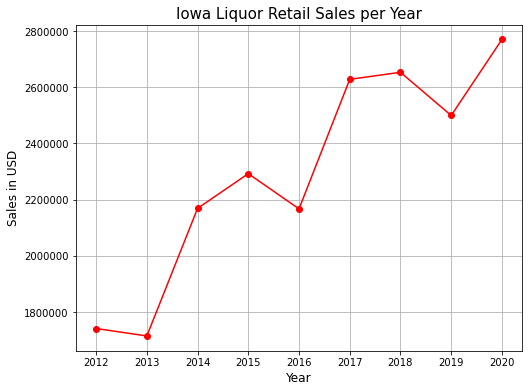

In [22]:
# Visualize the data
fig = plt.figure(figsize=(8, 6))
plot_1 = iowa_df_yearly_sales.plot(kind='line', 
                               color='red', 
                               marker='o', 
                               grid=True)
plot_1 = plt.title('Iowa Liquor Retail Sales per Year', fontsize=15)
plot_1 = plt.xlabel('Year', fontsize=12)
plot_1 = plt.ylabel('Sales in USD', fontsize=12)
plot_1 = plt.ticklabel_format(style='plain')
plot_1

In [31]:
# Save yearly sales plot to html file
dp.Report(dp.Plot(fig)).save(path='Iowa Liquor Yearly Sales.html', open=True)

Report saved to ./Iowa Liquor Yearly Sales.html

Según este gráfico de líneas, parece que la cantidad de licor vendido aumenta cada año con la mayor inclinación entre 2016 y 2017. Sin embargo, comienza a disminuir un poco durante 2019 y 2020. Como se ve en este gráfico, la cantidad de licor vendidos en 2020 es menor que en años anteriores, se debe a que hubo una pandemia mundial alrededor de 2020 y hasta el día de hoy.


## Iowa Liquor Retail Monthly Sales per Year

In [26]:
# Groupby 'Year' and 'Month' columns using sum() of 'sale_dollars' column
iowa_df_monthly_sales = iowa_df.groupby(['Year','Month'])['sale_dollars'].sum()
iowa_df_monthly_sales

Year  Month
2012  1         96508.03
      2        101220.32
      3        114083.39
      4        108062.27
      5        127604.68
                 ...    
2020  8        219038.90
      9        285457.43
      10       255571.09
      11       275986.88
      12       361925.19
Name: sale_dollars, Length: 108, dtype: float64

<AxesSubplot:xlabel='Year,Month'>

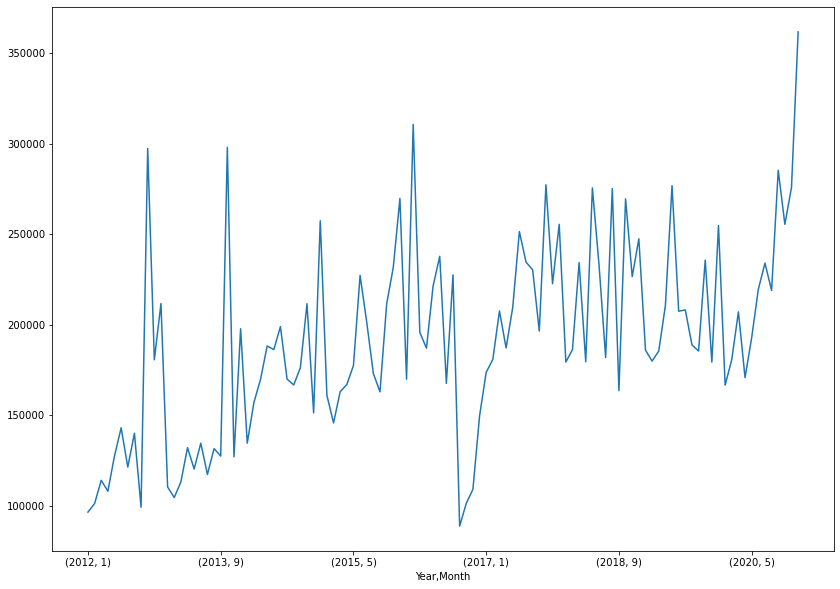

In [50]:
iowa_df_monthly_sales.plot(figsize=(14, 10))

Text(-32.5, 525000, 'Sales in USD')

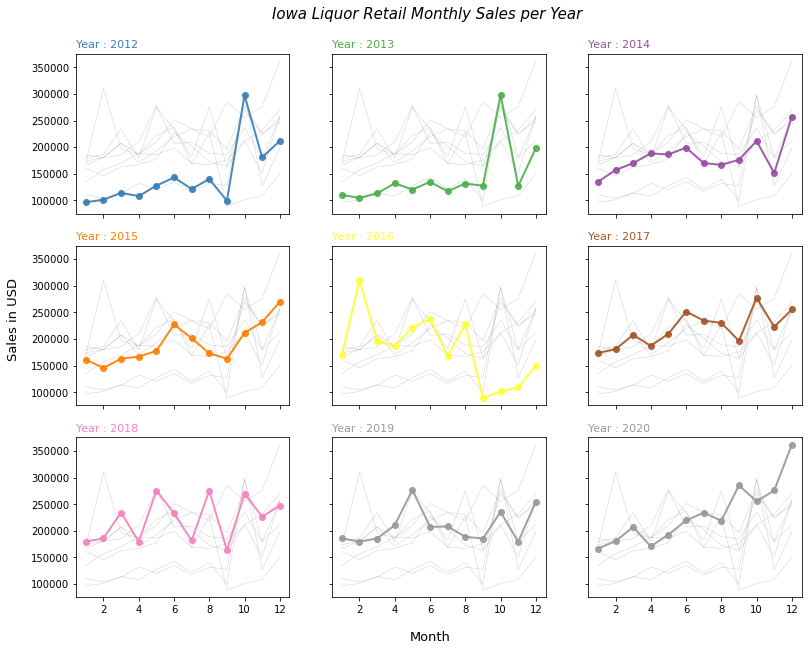

In [27]:
# Adjust plot size
fig = plt.figure(figsize=(13, 10))

# create a color palette
palette = plt.get_cmap('Set1')

# Multi-line plot
xs_index = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
num = 0
for xs in xs_index:
    num += 1
    
    #create a sub-plot (use num to set position of each plot)
    plt.subplot(3,3,num)    
    
    # plot every group, but using slightly deemed color
    for x in xs_index:
        iowa_df_monthly_sales.xs(x).plot(color='grey', linewidth=0.6, alpha=0.3)
    
    iowa_df_monthly_sales.xs(xs).plot(marker='o', color=palette(num), linewidth=2, alpha=0.9, label=xs)
    
    #Remove xlabel
    plt.xlabel("")
    
    # Set y limit for every plot
    plt.xlim()
    plt.ylim()
    
    # Remove unnecessary x and y ticks
    if num in range(7):
        plt.tick_params(axis='x',labelbottom=False)
    if num not in [1,4,7]:
        plt.tick_params(labelleft=False)
        
    # Add title for each plot
    plt.title('Year : {}'.format(xs), loc='left', fontsize=11, fontweight=0, color=palette(num))

# Add general title
plt.suptitle("Iowa Liquor Retail Monthly Sales per Year", fontsize=15, fontweight=0, color='black', style='italic', y=0.945)

# Axis title
plt.text(-8.5, 0.02, 'Month', ha='center', va='center', fontsize=13)
plt.text(-32.5, 525000, 'Sales in USD', rotation='vertical', fontsize=13) 

In [28]:
# Save yearly sales plot to html file
dp.Report(dp.Plot(fig)).save(path='Iowa Liquor Monthly Sales.html', open=True)

Report saved to ./Iowa Liquor Monthly Sales.html

In [30]:
# Publish plot to datapane Report.upload
dp.Report(dp.Plot(fig)).upload(name='Iowa Liquor Monthly Sales 2012-2020')

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? More info <a href='https://docs.datapane.com/reports/blocks/layout-pages-and-selects' target='_blank'>here</a>

Report successfully uploaded. View and share your report <a href='https://datapane.com/reports/mA2v62A/iowa-liquor-monthly-sales-2012-2020/' target='_blank'>here</a>, or edit your report <a href='https://datapane.com/reports/mA2v62A/iowa-liquor-monthly-sales-2012-2020/edit/' target='_blank'>here</a>.

Con base en este gráfico de varias líneas, descubrimos que en octubre y diciembre de cada año las ventas de licor están por encima de los 250 000 USD, con la única excepción de octubre de 2014, octubre de 2016 y diciembre de 2016 donde las ventas de licor están por debajo de los 250 000 USD.

La razón detrás de la gran cantidad de ventas de licores que se produjeron en octubre y diciembre es que hay varios días festivos y festivales en los EE. UU. durante estos meses. Uno de los más populares en octubre es Halloween, pero también hay celebración del Mes Nacional de la Herencia Hispana, el Día de la Hispanidad y el Día de los Pueblos Indígenas. En diciembre, hay día de Navidad y también celebración de Año Nuevo.

**Los 5 tipos principales de licores vendidos por año**

Debido a que parte del nombre de la categoría en la columna 'category_name' tiene una cadena de caracteres larga, es difícil visualizar todas las subparcelas si tenemos que usar 'category_name' como etiquetas. Entonces tengo que dividir estas 9 parcelas en un grupo de 3 parcelas, que es 2012 - 2014, 2015 - 2017, 2018 - 2020.

Debido a que tengo que repetir este proceso varias veces, defino una función para visualizar todas las subparcelas en un grupo, donde un grupo consta de 3 parcelas. Pero antes de definir una función, tengo que recopilar los datos sobre los 5 mejores licores vendidos cada año.

## Top 5 Types of Liquor Sold per Year

In [32]:
top_5_liquor_per_year = iowa_df.groupby(['Year','category_name']).agg({'sale_dollars':sum})
top_5_liquor_per_year = top_5_liquor_per_year['sale_dollars'].groupby('Year', group_keys=False).nlargest(5)

In [52]:
top_5_liquor_per_year

Year  category_name                  
2012  STRAIGHT RYE WHISKIES               293155.95
      IMPORTED DRY GINS                   182402.15
      DECANTERS & SPECIALTY PACKAGES      130163.80
      IRISH WHISKIES                      127323.03
      COFFEE LIQUEURS                     120855.09
2013  IMPORTED DRY GINS                   200567.12
      IRISH WHISKIES                      165706.21
      DECANTERS & SPECIALTY PACKAGES      161406.17
      STRAIGHT RYE WHISKIES               142478.11
      DISTILLED SPIRITS SPECIALTY         129357.62
2014  TEQUILA                             522571.63
      IMPORTED DRY GINS                   206864.01
      DECANTERS & SPECIALTY PACKAGES      201651.86
      IRISH WHISKIES                      174172.66
      SINGLE MALT SCOTCH                  151148.25
2015  TEQUILA                             430169.18
      IRISH WHISKIES                      274194.10
      IMPORTED DRY GINS                   251648.07
      SINGLE MALT SCOTCH  

In [34]:
# Define a function to visualize all the subplots in a group
def TopFivePerYear(data, year_1, year_2, num=0):
    # Adjust plot size
    fig = plt.figure(figsize=(7, 10))

    # create a color palette
    palette = plt.get_cmap('Set1')

    # Multi-line plot
    year_to_year = list(range(year_1, year_2 + 1))
    num = 0
    for year in year_to_year:        
        num += 1
        
        #create a sub-plot (use num to set position of each plot)
        plt.subplot(3,1,num)    
    
        data.xs(year).plot(kind='barh', color=palette(num), linewidth=2, alpha=0.9, label=year)
    
        # Change the y ticklabel format from scientific to plain
        plt.ticklabel_format(axis='x', style='plain')
    
        plt.xticks(rotation=0)
    
        # Remove x and y label
        plt.ylabel("")
        plt.xlabel("Sales in USD", fontsize=11)
    
        # Set y limit for every plot
        plt.xlim(0, 1200000)
    
        # Remove unnecessary x and y ticks
        if num in [1, 2]:
            plt.tick_params(labelbottom=False)
            plt.xlabel("")
        
        # Add title for each plot
        plt.title('Year : {}'.format(year), loc='center', fontsize=11, fontweight=0, color=palette(num))

    # Add general title
    plt.suptitle("Top 5 Types of Liquor Sold ({} - {})".format(year_1, year_2), fontsize=15, fontweight=0, color='black', style='italic', y=0.945)

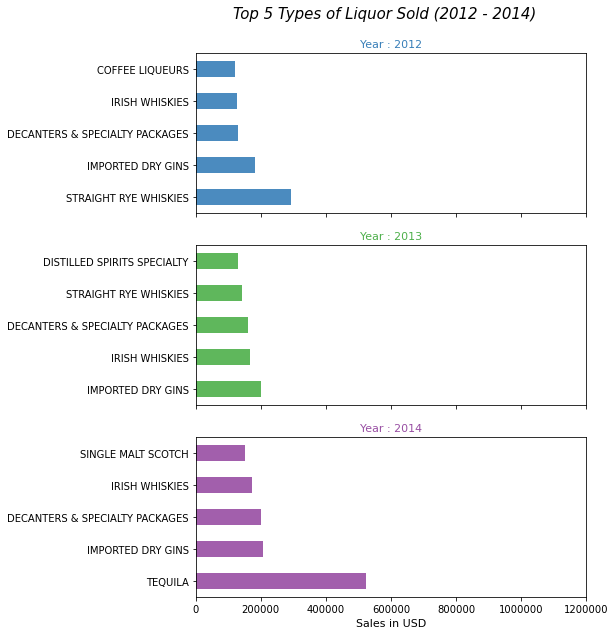

In [35]:
# Top 5 Types of Liquor Sold in 2012 to 2014
TopFivePerYear(top_5_liquor_per_year,2012,2014)

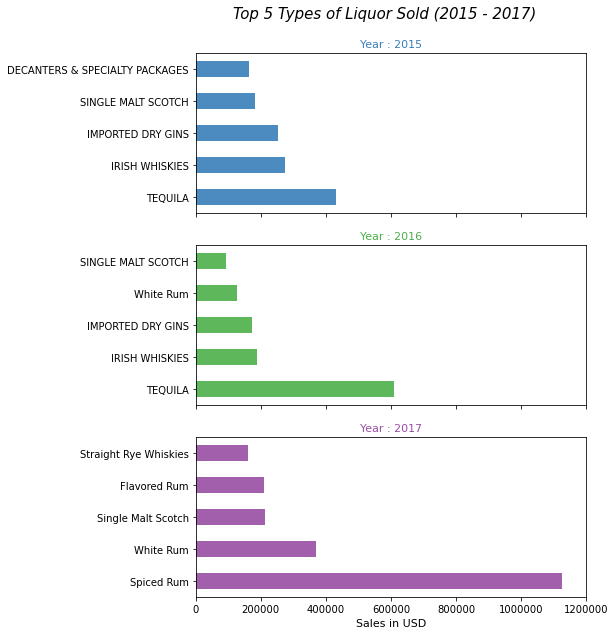

In [36]:
# Top 5 Types of Liquor Sold in 2015 to 2017
TopFivePerYear(top_5_liquor_per_year,2015,2017)

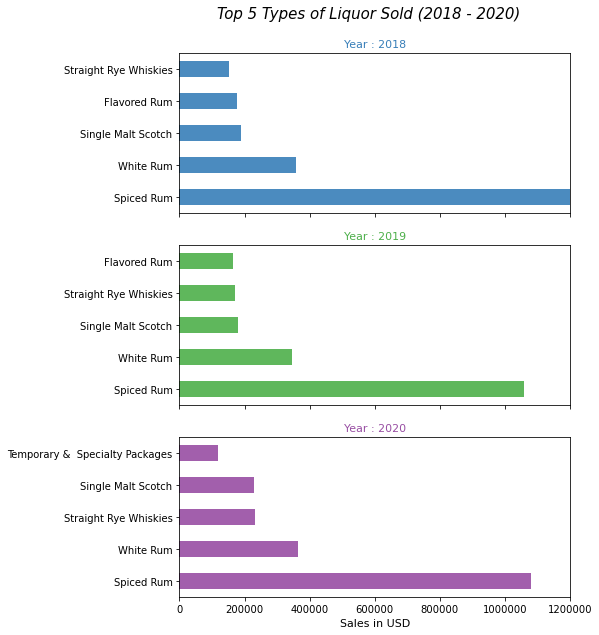

In [37]:
# Top 5 Types of Liquor Sold in 2015 to 2017
TopFivePerYear(top_5_liquor_per_year,2018,2020)

Durante 4 años seguidos, de 2012 a 2015, los whiskies son los más populares en Iowa y le siguen el tequila en 2016. Luego, a partir de 2017, tanto el ron blanco como el ron especiado dominan el mercado en Iowa con las ventas más altas que superaron el millón de dólares en 2017. A partir de estos gráficos, podemos ver que la demanda en el mercado estaba cambiando de whisky a ron.

## Top 3 Brands From Most Favorite Type of Liquor per Year

In [40]:
top_3_brand_per_year = iowa_df.groupby(['Year','category_name','item_description']).agg({'sale_dollars':'sum'})
top_3_brand_per_year = top_3_brand_per_year['sale_dollars'].groupby(['Year','category_name'], group_keys=False).nlargest(3)
top_3_brand_per_year


Year  category_name      item_description      
2012  100 PROOF VODKA    Mccormick Vodka Pet        41324.67
                         Mccormick Vodka            14329.44
                         Smirnoff Vodka 100 Prf     10169.99
      AMERICAN ALCOHOL   Everclear Alcohol          32282.29
      AMERICAN AMARETTO  Paramount Amaretto         28280.43
                                                     ...    
2020  Triple Sec         Juarez Triple Sec          11531.92
                         Dekuyper Triple Sec        10531.50
      White Rum          Bacardi Superior          165087.24
                         Bacardi Superior PET       61132.14
                         Paramount White Rum        52922.01
Name: sale_dollars, Length: 937, dtype: float64

In [53]:
# Define a function to visualize all the subplots in a group
def TopBrandPerYear(data, year_1, year_2, num=0):
    # Adjust plot size
    fig = plt.figure(figsize=(7, 10))

    # create a color palette
    palette = plt.get_cmap('Set1')

    # Multi-line plot
    year_to_year = list(range(year_1, year_2 + 1))
    fav_liquor_per_year = {2012:'STRAIGHT RYE WHISKIES', 
                           2013:'IRISH WHISKIES', 
                           2014:'IRISH WHISKIES', 
                           2015:'IRISH WHISKIES', 
                           2016:'TEQUILA', 
                           2017:'Spiced Rum',
                           2018:'Spiced Rum',
                           2019:'Spiced Rum', 
                           2020:'White Rum'}
    num = 0
    for year in year_to_year:
        num += 1
    
        #create a sub-plot (use num to set position of each plot)
        plt.subplot(3,1,num)    
    
        data.xs((year, fav_liquor_per_year.get(year))).plot(kind='barh', 
                                                            color=palette(num), 
                                                            linewidth=2, 
                                                            alpha=0.9, 
                                                            label=year)
    
        # Change the x ticklabel format from scientific to plain
        plt.ticklabel_format(axis='x', style='plain')
    
        plt.xticks(rotation=0)
    
        # Remove y label and rename x label
        plt.ylabel("")
        plt.xlabel("Sales in USD", fontsize=11)
    
        # Set y limit for every plot
        plt.xlim(0, 500000)
    
        # Remove unnecessary x and y ticks
        if num in [1, 2]:
            plt.tick_params(labelbottom=False)
            plt.xlabel("")
        
        # Add title for each plot
        plt.title('Year : {} ({})'.format(year, fav_liquor_per_year.get(year)), 
                  loc='center', 
                  fontsize=11, 
                  fontweight=0, 
                  color=palette(num))

    # Add general title
    plt.suptitle("Top 3 Brands From Most Favourite Type of Liquor Sold ({} - {})".format(year_1, year_2), 
                 fontsize=15, 
                 fontweight=0, 
                 color='black', 
                 style='italic', 
                 y=0.945)

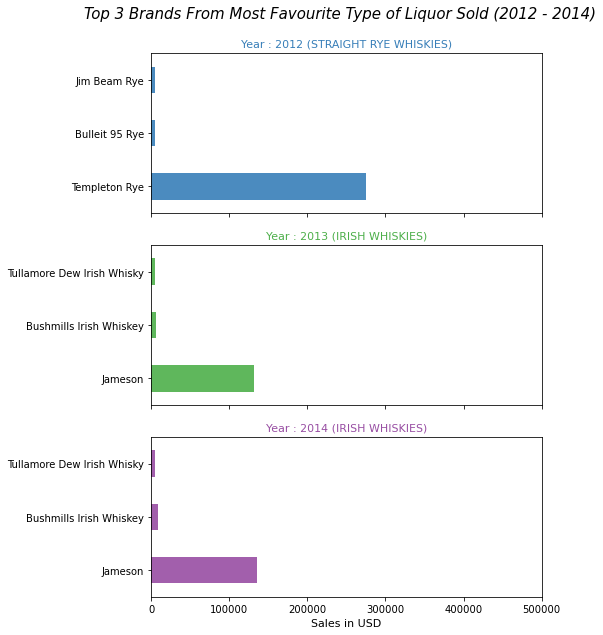

In [54]:
# Top 3 Brands 2012 - 2014
TopBrandPerYear(top_3_brand_per_year,2012,2014)

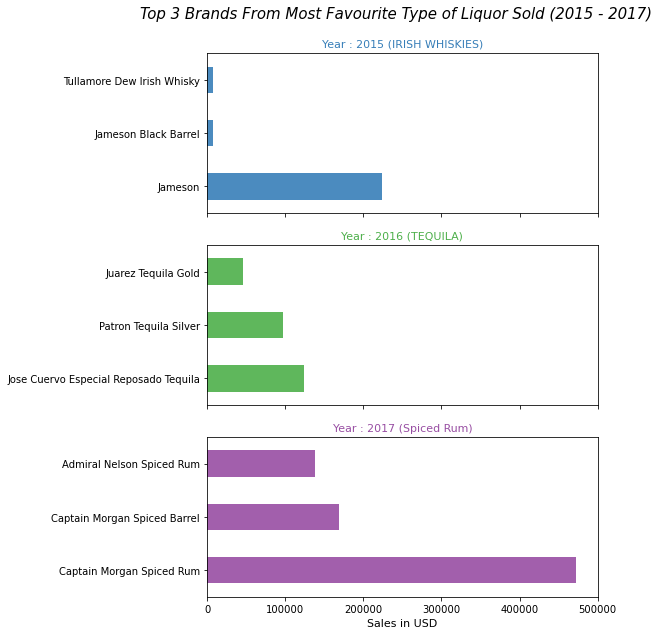

In [55]:
# Top 3 Brands 2015 - 2017
TopBrandPerYear(top_3_brand_per_year,2015,2017)

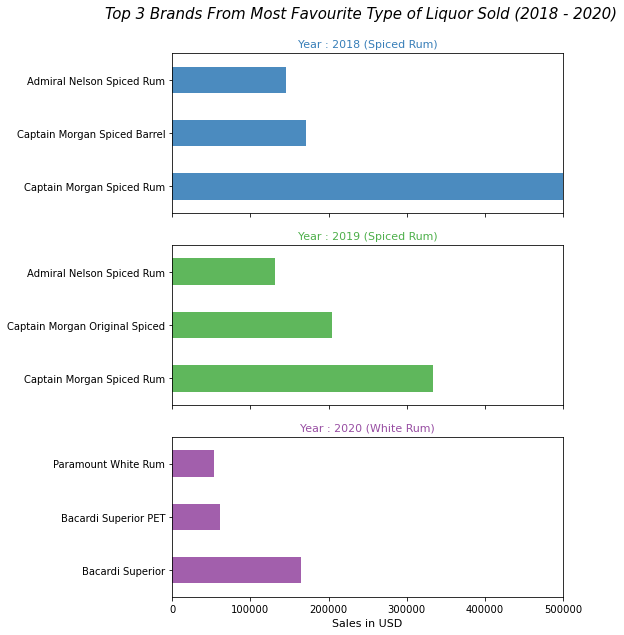

In [56]:
# Top 3 Brands 2018 - 2020
TopBrandPerYear(top_3_brand_per_year,2018,2020)

En resumen de estos gráficos Top 3 Brands, es cierto que de cada tipo de licor, sin importar el año que sea, la marca es siempre la misma. Por ejemplo, la mejor marca de whisky irlandés cada año siempre es Jameson (¡Jameson es un buen whisky!), el ron especiado siempre es Captain Morgan, y para el ron blanco parece que Bacardí es... Superior. (Juego de palabras intencionado).

## Top 100 Big Spenders in Iowa in 2020

La ciudad capital del estado de Iowa es Des Moines, y también es una ciudad metropolitana. Basado solo en esta información, no tengo dudas de que la gran cantidad de ventas ocurrió en este condado, pero todavía tengo curiosidad sobre si esa afirmación es cierta o no. Por lo tanto, usaré 100 filas de datos de la columna 'ubicación_tienda' para identificar la ubicación de cada tienda que tiene la mayor cantidad de valor de transacción.

En este análisis, requiero una API llamada Nominatim. Nominatim es una API que usa datos para encontrar ubicaciones en la Tierra por nombre y dirección. También puede hacer lo contrario, encontrar una dirección para cualquier lugar del planeta. Este método se llama Geocodificación.

In [58]:
# Create new dataframe that only contains necessary columns
top_100_spenders_2020 = iowa_df.loc[iowa_df['Year'] == 2020]
top_100_spenders_2020 = top_100_spenders_2020.nlargest(100, 'sale_dollars')

In [59]:
# Collect Iowa's coordinate
coord_iowa = 'Iowa, United States of America'
geolocator_iowa = Nominatim(user_agent='chris_p_bacon_xD')
location_iowa = geolocator_iowa.geocode(coord_iowa)
latitude_iowa = location_iowa.latitude
longitude_iowa = location_iowa.longitude
print('The geographical coordinate of Iowa are {}, {}'.format(latitude_iowa, longitude_iowa))

# Create a Map of Iowa
map_iowa = folium.Map(location=[latitude_iowa, longitude_iowa], zoom_start=7.5)

# Add markers to the map
for lat, lng, city, county in zip(top_100_spenders_2020['store_lat'], 
                          top_100_spenders_2020['store_lng'], 
                          top_100_spenders_2020['city'], 
                          top_100_spenders_2020['county']):
    label = 'City: {} | County: {}'.format(city, county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                       radius=5,
                       popup=label,
                       color='blue',
                       fill=True,
                       fill_color='#FFD700',
                       fill_opacity=0.7,
                       parse_html=False).add_to(map_iowa)

map_iowa

The geographical coordinate of Iowa are 41.9216734, -93.3122705


In [60]:
# Save yearly sales plot to html file
dp.Report(dp.Plot(map_iowa)).save(path='Map of Iowa.html', open=True)

Report saved to ./Map of Iowa.html

In [63]:
# Publish plot to datapane
dp.Report(dp.Plot(map_iowa)).upload(name='Map of Iowa')


Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? More info <a href='https://docs.datapane.com/reports/blocks/layout-pages-and-selects' target='_blank'>here</a>

Report successfully uploaded. View and share your report <a href='https://datapane.com/reports/8AV6KQA/map-of-iowa/' target='_blank'>here</a>, or edit your report <a href='https://datapane.com/reports/8AV6KQA/map-of-iowa/edit/' target='_blank'>here</a>.

## Correlation Map

Antes de proceder a crear un mapa de calor para encontrar la correlación entre cada columna (variable), tengo que crear un nuevo marco de datos que elimine las columnas innecesarias, y quiero ajustar las columnas en este nuevo marco de datos para que sea compatible para construir un ML modelo.

In [64]:
# Drop unnecessary columns from iowa_df dataframe to create new dataframe for ML model
iowa_sales_df = iowa_df.drop(['invoice_and_item_number',
                              'date',
                              'store_number',
                              'store_name',
                              'address',
                              'zip_code',
                              'store_location',
                              'county_number',
                              'county',
                              'category',
                              'category_name',
                              'vendor_number',
                              'vendor_name',
                              'item_number',
                              'item_description',
                              'pack','Quarter',
                              'store_lng',
                              'store_lat'], axis=1)
iowa_sales_df.head()

,city,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Year,Month
0,CORNING,1750,31.00,46.50,8,372.00,14.0,3.70,2012,10
1,NORTH LIBERTY,750,13.00,19.50,18,351.00,13.5,3.57,2012,10
2,AMES,1000,7.35,11.02,4,44.08,4.0,1.06,2012,10
3,ARMSTRONG,1000,3.00,4.50,4,18.00,4.0,1.06,2012,7
4,BOONE,1000,11.24,16.86,4,67.44,4.0,1.06,2012,6


Según las variables independientes que seleccioné (excepto las columnas 'ciudad', 'Año', 'Mes', y también dado que la columna 'sale_dollars' es una variable de destino), la columna bottle_volume_ml es un valor categórico. Para crear un modelo de ML, en este caso Regresión lineal, tengo que desglosar estos valores categóricos en nuevas columnas. Veamos cómo se distribuyen los valores categóricos en la columna 'bottle_volume_ml'.

In [65]:
iowa_sales_df['bottle_volume_ml'].value_counts()[0:10]

750     81542
1000    25550
1750    19179
375      8808
500      4083
200      1855
50       1744
600       586
300       243
850        68
Name: bottle_volume_ml, dtype: int64

Parece que 750 ml, 1000 ml y 1750 ml son el tipo más común. Luego crearé 4 columnas nuevas para cada tipo de volumen de botella (la 4.ª columna sería el resto del tipo de volumen de botella).

In [66]:
# Create new column for 750ml
iowa_sales_df['vol_750ml_sale_dollars'] = np.where(iowa_sales_df['bottle_volume_ml'] == 750, 
                                                   iowa_sales_df['sale_dollars'], 0)

# Create new column for 1000ml
iowa_sales_df['vol_1000ml_sale_dollars'] = np.where(iowa_sales_df['bottle_volume_ml'] == 1000, 
                                                    iowa_sales_df['sale_dollars'], 0)

# Create new column for 1750ml
iowa_sales_df['vol_1750ml_sale_dollars'] = np.where(iowa_sales_df['bottle_volume_ml'] == 1750, 
                                                    iowa_sales_df['sale_dollars'], 0)

# Create new column for other bottle types
conditions = (iowa_sales_df['bottle_volume_ml'] != 750) | (iowa_sales_df['bottle_volume_ml'] != 1000) | (iowa_sales_df['bottle_volume_ml'] != 1750)
value = iowa_sales_df['sale_dollars'] - (iowa_sales_df['vol_750ml_sale_dollars'] + iowa_sales_df['vol_1000ml_sale_dollars'] + iowa_sales_df['vol_1750ml_sale_dollars'])
iowa_sales_df['other_vol_sale_dollars'] = np.where(conditions, value, 0)

In [67]:
# Remove 'bottle_volume_ml' column
iowa_sales_df.drop(['bottle_volume_ml'], axis=1, inplace=True)

In [68]:
iowa_sales_df.head()

,city,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Year,Month,vol_750ml_sale_dollars,vol_1000ml_sale_dollars,vol_1750ml_sale_dollars,other_vol_sale_dollars
0,CORNING,31.00,46.50,8,372.00,14.0,3.70,2012,10,0.0,0.00,372.0,0.0
1,NORTH LIBERTY,13.00,19.50,18,351.00,13.5,3.57,2012,10,351.0,0.00,0.0,0.0
2,AMES,7.35,11.02,4,44.08,4.0,1.06,2012,10,0.0,44.08,0.0,0.0
3,ARMSTRONG,3.00,4.50,4,18.00,4.0,1.06,2012,7,0.0,18.00,0.0,0.0
4,BOONE,11.24,16.86,4,67.44,4.0,1.06,2012,6,0.0,67.44,0.0,0.0


In [69]:
# Readjust dataframe
iowa_sales_df = iowa_sales_df.groupby(['Year','Month']).sum()
iowa_sales_df.reset_index(inplace=True)

In [70]:
# Save 'iowa_sales_df' dataframe to csv
iowa_sales_df.to_csv('iowa_sales_df.csv', index=False)

La regresión lineal es un enfoque estadístico para modelar la relación entre una variable dependiente (sale_dollars) con un conjunto determinado de variables independientes. Este conjunto de datos contiene el registro de ventas de licores de 2012 a 2020. Usaré el método de regresión lineal para predecir las ventas en 2020.

In [72]:
# Create corr variable to save correlation of each column results
corr = iowa_sales_df[iowa_sales_df.columns[2:]].corr(method='pearson')
corr

,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,vol_750ml_sale_dollars,vol_1000ml_sale_dollars,vol_1750ml_sale_dollars,other_vol_sale_dollars
state_bottle_cost,1.000000,0.999987,0.735049,0.800669,0.633047,0.633051,0.705557,0.516965,0.362138,0.601538
state_bottle_retail,0.999987,1.000000,0.735294,0.800926,0.632532,0.632542,0.708055,0.516841,0.360195,0.600874
bottles_sold,0.735049,0.735294,1.000000,0.949507,0.951668,0.952191,0.677953,0.621259,0.611191,0.580704
sale_dollars,0.800669,0.800926,0.949507,1.000000,0.915083,0.915227,0.748458,0.541788,0.658579,0.633864
volume_sold_liters,0.633047,0.632532,0.951668,0.915083,1.000000,0.999993,0.493080,0.504490,0.806486,0.517573
volume_sold_gallons,0.633051,0.632542,0.952191,0.915227,0.999993,1.000000,0.494101,0.505393,0.805271,0.517500
vol_750ml_sale_dollars,0.705557,0.708055,0.677953,0.748458,0.493080,0.494101,1.000000,0.339902,0.082616,0.407234
vol_1000ml_sale_dollars,0.516965,0.516841,0.621259,0.541788,0.504490,0.505393,0.339902,1.000000,0.076723,0.391395
vol_1750ml_sale_dollars,0.362138,0.360195,0.611191,0.658579,0.806486,0.805271,0.082616,0.076723,1.000000,0.363784
other_vol_sale_dollars,0.601538,0.600874,0.580704,0.633864,0.517573,0.517500,0.407234,0.391395,0.363784,1.000000


[Text(0.5, 0, 'state_bottle_cost'),
 Text(1.5, 0, 'state_bottle_retail'),
 Text(2.5, 0, 'bottles_sold'),
 Text(3.5, 0, 'sale_dollars'),
 Text(4.5, 0, 'volume_sold_liters'),
 Text(5.5, 0, 'volume_sold_gallons'),
 Text(6.5, 0, 'vol_750ml_sale_dollars'),
 Text(7.5, 0, 'vol_1000ml_sale_dollars'),
 Text(8.5, 0, 'vol_1750ml_sale_dollars'),
 Text(9.5, 0, 'other_vol_sale_dollars')]

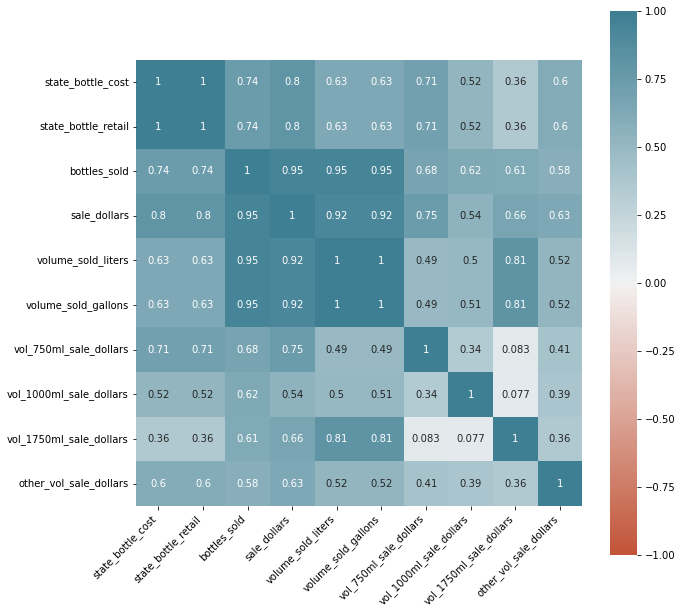

In [73]:
# Create Heatmap
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr,
    annot=True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

Based on the correlation value generated by the heatmap, we can see that in sale_dollars columns, the lowest value is 0.54 which is the correlation between 'sale_dollars' and 'other_vol_sale_dollars'. I am going to use this dataset to build a Machine Learning - Linear Regression Model to predict the sales in 2020.


# Formulación de Modelo

Para construir el modelo ML, el conjunto de datos debe dividirse en dos partes, que es el conjunto de entrenamiento y prueba. El conjunto de entrenamiento se usará para entrenar el modelo de Machine Learning, mientras que el conjunto de prueba se usará para calcular la precisión del modelo previamente entrenado. Nuestro objetivo es predecir las ventas, lo que significa que nuestra variable objetivo/dependiente es la columna 'sale_dollars', mientras que las otras columnas son nuestras variables independientes.

In [75]:
# Create train and test dataset
train_df = iowa_sales_df[iowa_sales_df.columns[2:]].loc[iowa_sales_df['Year'] != 2020]
test_df = iowa_sales_df[iowa_sales_df.columns[2:]].loc[iowa_sales_df['Year'] == 2020]
print(train_df.shape, test_df.shape)

# Create new variables called X_train, y_train, X_test, y_test
X_train = train_df.drop(['sale_dollars', 'bottles_sold', 'volume_sold_liters', 'volume_sold_gallons', 'other_vol_sale_dollars'], axis=1)
y_train = train_df['sale_dollars']
X_test = test_df.drop(['sale_dollars', 'bottles_sold', 'volume_sold_liters', 'volume_sold_gallons', 'other_vol_sale_dollars'], axis=1)
y_test = test_df['sale_dollars']

(96, 10) (12, 10)


Variance Score: 0.99153643381392


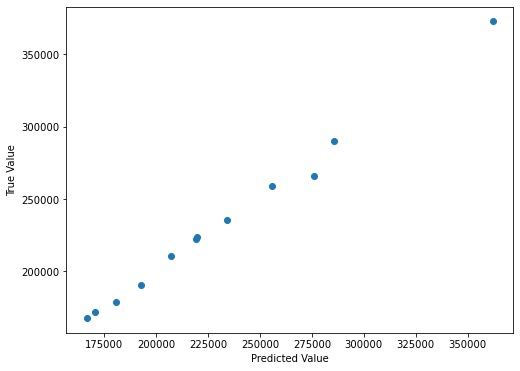

In [76]:
# Instantiate linear model for ease of coding below
lm = linear_model.LinearRegression()

# Fit our X_train and y_train variables to train the model
model = lm.fit(X_train, y_train)

# Use X_test and y_test variables to predict new data using the model
predict = lm.predict(X_test)

# Using scatter plot to see the result
fig = plt.figure(figsize=(8,6))
plt.scatter(y_test, predict)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')

# Check variance score, 
print('Variance Score: {}'.format(model.score(X_test, y_test)))

In [77]:
# Create new dataframe 'iowa_sales_2020'
iowa_sales_2020 = iowa_sales_df.loc[iowa_sales_df['Year'] == 2020]

# Insert the prediction result to Iowa sales in 2020 dataframe
iowa_sales_2020['sale_dollars_pred'] = predict

/var/folders/9j/5yzg7cn96fzbg902v4qrs08r0000gn/T/ipykernel_64748/3163443423.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iowa_sales_2020['sale_dollars_pred'] = predict


In [78]:
# Create new variable that saves predicted sales in 2020 value
grouped_iowa_sales_2020 = iowa_sales_2020.groupby('Year')['sale_dollars_pred'].sum()

# Create new variable to replace sales in 2020 to predicted sales in 2020
pred_iowa_df_yearly_sales = iowa_df_yearly_sales.replace(iowa_df_yearly_sales[2020], grouped_iowa_sales_2020.sum())

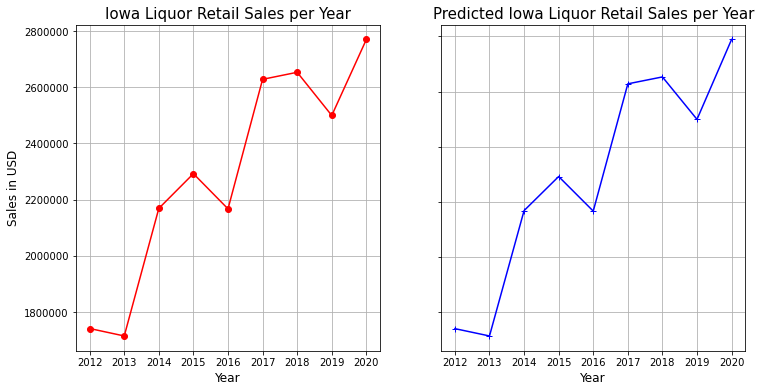

In [79]:
# Visualize the data
fig = plt.figure(figsize=(12, 6))

# subplot 1 - Liquor Sales per Year
plt.subplot(1,2,1)  
iowa_df_yearly_sales.plot(kind='line', 
                          color='red', 
                          marker='o', 
                          grid=True)
plt.title('Iowa Liquor Retail Sales per Year', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales in USD', fontsize=12)
plt.ticklabel_format(style='plain')

# subplot 2 - Predicted Liquor Sales per Year
plt.subplot(1,2,2)
pred_iowa_df_yearly_sales.plot(kind='line', 
                          color='blue', 
                          marker='+', 
                          grid=True)
plt.title('Predicted Iowa Liquor Retail Sales per Year', fontsize=15)
plt.tick_params(labelleft=False)
plt.xlabel('Year', fontsize=12)
plt.ticklabel_format(style='plain')

In [80]:
# Save yearly sales plot to html file
dp.Report(dp.Plot(fig)).save(path='Iowa Liquor Yearly Sales vs Predicted', open=True)

Report saved to ./Iowa Liquor Yearly Sales vs Predicted

In [81]:
# Publish plot to datapane
dp.Report(dp.Plot(fig)).upload(name='Iowa Liquor Yearly Sales vs Predicted')

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? More info <a href='https://docs.datapane.com/reports/blocks/layout-pages-and-selects' target='_blank'>here</a>

ReadTimeout: HTTPSConnectionPool(host='datapane.com', port=443): Read timed out. (read timeout=54)